In [37]:
import dclllib
import torch.nn as nn
from torch.nn import functional as F
import torch
import numpy as np
import pylab as plt
device = 'cpu'

# Synaptic Plasticity with Deep Continuous Local Learning
This is a tutorial for setting up spiking neurla networks for learning with local errors. The reader is assumed to be familier with Python and Pytorch.

## Setting up the LIF network

In this tutorial, you will learn how to implement a spiking neural network in PyTorch, set up a learning framework for a one layer, and extend this to multiple layers using local errors. The plasticity rules will be derived using PyTorch's autodifferentiation tools. The theory and further background can be found <a href="https://arxiv.org/abs/1811.10766">here</a> and <a href="https://arxiv.org/abs/1901.09948">here</a>.

First, let's start by exploring LIF neuron dynamics in PyTorch. In discrete time, the neuron update rule can be written <a href="https://arxiv.org/abs/1901.09948">(Neftci, Mostafa, Zenke, 2019)</a>:

$$
\begin{align*}
    U_i[n+1] & = \beta U_i[n] + I_i[n] - S_i[n] \\
    I_i[n+1] & = \alpha I_i[n] + \sum_j W_{ij} S_j[n] + b
\end{align*}
$$

where $U_i[n]$ is the membrane potential at time step $n$, $\alpha=\exp(-\frac{\Delta t}{\tau_{\mathrm{mem}}})$ and $\beta=\exp(-\frac{\Delta t}{\tau_{\mathrm{syn}}})$ are constants that capture the decay dynamics of states $U$ and $I$ during a $\Delta t$ timestep ($\tau_\mathrm{mem}$ and $\tau_{syn}$ are the membrane and synaptic time constants, respectively). $W$ here is the connectivity matrix between the neurons. When $U_i$ exceeds the firing theshold, the membrane potential is reset and integration continues.
Both $U_i$ and $I_i$ act as leaky integrator of the input current $I_i$, which itself is a leaky, weighted integration of the spike train $S_j[n]=\Theta(U_i)$. In other words, for each incoming spike the synaptic current undergoes a jump of height ${W_{ij}}$ and otherwise decays exponentially with a time constant $\tau_{\mathrm{syn}}$. $b$ above can be interepreseted as a constant current injection.


In PyTorch, these dynamics can be implemented in a straightfoward way. Let us first define the states. For this we used a named tuple, which is a set where elements can be conveniently identified using names,

In [38]:
from collections import namedtuple
NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])

where S is a binary vector representing the spiking state of the neuron. 

Let us now define an initial state for N=10 neurons

In [39]:
N=10

In [40]:
state = NeuronState(U=torch.zeros(N), I=torch.zeros(N), S=torch.zeros(N))

You might be surprised hbere that S is a tesnor of type float. This is because we will leverage existing tensor operations in pytorch that operate on dense vectors. 

When using GPUs, spike trains can be conveniently (but not so efficiently) represented as a binary vector. The following function from the library creates a Poisson spike spike, i.e. a spike train of given firing with no spike-to-spike correlations.

In [41]:
Sin = torch.FloatTensor(dclllib.spiketrains(N=10, T=1000, rates = np.ones([10])*5))

The following plots the spike train. For the moment, don't worry about the U=None argument, this is because the same function can be used to plot membrane potential traces.

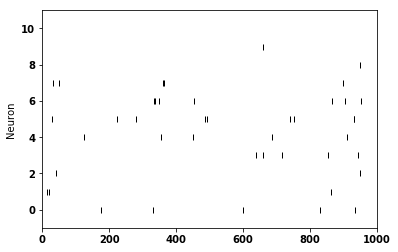

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc96c338e80>, None)

In [42]:
dclllib.plotLIF(U=None, S=Sin.data.numpy())

Now we're getting ready to define the SNN dynamics. First we need to define the parameters $W$ and $b$

In [43]:
weight =  nn.Parameter(torch.zeros(N,N))
bias =  nn.Parameter(torch.zeros(N))
alpha = float(np.exp(-1e-3/20e-3))
beta = float(np.exp(-1e-3/10e-3))

In [44]:
#Initialize
weight.data.uniform_(-.3,.3)
bias.data.uniform_(-.01,.01)

tensor([-0.0041, -0.0019,  0.0044,  0.0069,  0.0096, -0.0071, -0.0088, -0.0030,
        -0.0078,  0.0078])

Let us now define the one step dynamics:

In [45]:
def forward(Sin_t, state):
    U = alpha*state.U + state.I - state.S
    I = beta*state.I + F.linear(Sin_t, weight, bias)
    # update the neuronal state
    S = (U>0).float()
    state = NeuronState(U=U, I=I, S=S)
    return state

In [46]:
Uprobe = np.empty([1000,N])
Iprobe = np.empty([1000,N])
Sprobe = np.empty([1000,N])
for n in range(1000):
    state = forward(Sin[n], state)
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    
    

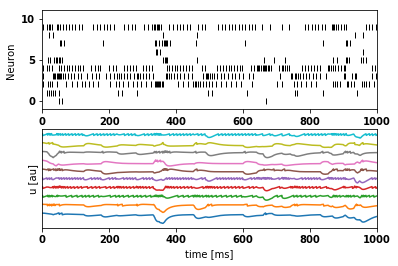

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc96c2a41d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc96c2c9da0>)

In [47]:
dclllib.plotLIF(U=Uprobe, S=Sprobe, staggering=5)

## Setting up the pyTorch LIF module

Now, let's use pytorch Module to encapsulate all these operations and clean up the code. For homogeniety with future code, we'll use in_channels and out_channels as variables names for the number of inputs and the number of neurons, respectively.

In [48]:
class LIFDensePopulation(nn.Module):
    NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])
    def __init__(self, in_channels, out_channels, bias=True, alpha = .9, beta=.85):
        super(LIFDensePopulation, self).__init__()        
        self.fc_layer = nn.Linear(in_channels, out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.state = state = self.NeuronState(U=torch.zeros(out_channels),
                                              I=torch.zeros(out_channels),
                                              S=torch.zeros(out_channels))
        self.fc_layer.weight.data.uniform_(-.3, .3)
        self.fc_layer.bias.data.uniform_(-.01, .01)
    
    def forward(self, Sin_t):
        state = self.state
        U = alpha*state.U + state.I - state.S
        I = beta*state.I + self.fc_layer(Sin_t)
        # update the neuronal state
        S = (U>0).float()
        self.state = NeuronState(U=U, I=I, S=S)
        return self.state
        

In [49]:
pop1 = LIFDensePopulation(10,10)

In [50]:
Uprobe = np.empty([1000,N])
Iprobe = np.empty([1000,N])
Sprobe = np.empty([1000,N])
for n in range(1000):
    state = pop1.forward(Sin[n])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()

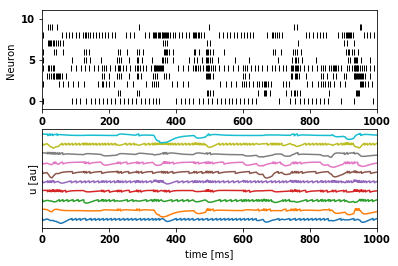

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc96c242f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc96c1f1c88>)

In [51]:
dclllib.plotLIF(U=Uprobe, S=Sprobe, staggering=5)

The results look qualitatively the same, which is a good sign.

## Setting up learning

Our spiking neural network is performing as expected, which is nothing interesting. That is because we didn't set the weights and biases in any particular way. Although there any many ways of setting ways for obtaining a given functionality, see for example the Neural Engineering Framework, our goal here is to train the weights and biases according to some data. Let's train a one-layer network for MNIST digita classification. As discussed in <a href="https://arxiv.org/abs/1901.09948">(Neftci, Mostafa, Zenke, 2019)</a>, the hard threshold non-linearity of the spiking neuron is problematic. There are many ways of avoiding this problem, and we'll start by learning on an artifial output probability. Then, we'll implement a custom activation function that implement the hard threshold in the forward operation, but a smooth (boxcar) function in the backward phase.

### Setting up synaptic plasticity

In order to create a plasticity rule, we will use gradient descent on a well known loss function, the mean-squared error. Since we have 10 classes, we will represent each class with one output neuron.  The objective is that the membrane potential of the neurons corresponding to the correct class be high (=1), otherwise (-1). :

$$ 
L = \sum_n (\sigma(U_i[n]) - \hat{y}_i[n])^2 
$$

where $\sigma$ is the sigmoid function. We're cheating here a bit: the output of the neuron were training is a smooth sigmoid function of the membrane potential. Let's assume for the moment that the neuron has access to this quantity (we will relax that later).

Taking the derivative of $L$ with respect to $W_{ij}$, we get:
$$
\frac{\mathrm{d}}{\mathrm{d} W_{ij}} L[n] = \text{error} \,\sigma'(U_i[n]) \frac{\mathrm{d}}{\mathrm{d} W_{ij}} U_i[n]
$$

The last term can be computed recursively:
$$
\begin{split}
\frac{\mathrm{d}}{\mathrm{d} W_{ij}} U_k[n+1] &= \beta \frac{\mathrm{d}}{\mathrm{d} W_{ij}} U_k[n] + \frac{\mathrm{d}}{\mathrm{d} W_{ij}} I_k[n] - \frac{\mathrm{d}}{\mathrm{d} W_{ij}} S_k[n] \\
\frac{\mathrm{d}}{\mathrm{d} W_{ij}} I_k[n+1] & = \alpha \frac{\mathrm{d}}{\mathrm{d} W_{ij}} I_k[n] + \frac{\mathrm{d}}{\mathrm{d} W_{ij}}  \sum_l W_{kl} S_l[n] 
\end{split}
$$

The recursiveness suggests us to represent $\frac{\mathrm{d}}{\mathrm{d} W_{ij}} U_k[n]$ and $\frac{\mathrm{d}}{\mathrm{d} W_{ij}} I_k[n]$ explicitely. Let's call them P and Q:


$$
\begin{split}
P_{ij}[n+1] &= \beta P_{ij}[n] + Q_{ij}[n] \\
Q_{ij}[n+1] &= \beta Q_{ij}[n] + S_j[n] \\
\end{split}
$$


Here we did two things. First, we ignored the term $- \frac{\mathrm{d}}{\mathrm{d} W_{ij}} S_k[n] $, as this term is difficult to calculate see (<a href="https://arxiv.org/abs/1901.09948">(Neftci, Mostafa, Zenke, 2019)</a>) for the discussion. Second, we assumed a feedforward connectivity, which allows us to equate $i$ and $k$.

We can also notice that the $i$ index above is unnecessary, since the only external input is indexed by $j$. This allows us to reduce these two equations to the following:
$$
\begin{split}
P_{j}[n+1] &= \alpha P_{j}[n] + Q_{j}[n] \\
Q_{j}[n+1] &= \beta Q_{j}[n] + S_j[n] \\
\end{split}
$$

And finally we obtain:
$$
\frac{\mathrm{d}}{\mathrm{d} W_{ij}} L[n] = \text{error} \,\sigma'(U_i[n]) P_j[n]
$$

This update rule can be used as a synaptic plasticity rule. It is tempting to implement this directly in PyTorch forward function and it would certainly work. However this would not allow us to use autodifferentiation. Its not a big deal here because fully connected layers involve easy operations, but it does become painful when convolutional layers are used. We can use a trick that will make us use the autodifferentiation functionalities. 

You may notice some familiarity with the equations $P$ and $Q$. These are almost the same as $U$ and $I$. The only difference is that $Q$ does not involve the weights or the biases. But the dynamics for $U$, and $I$ are linear, so whether we weight $Q$ or $S$ doesn't matter. In other words:
$$
\begin{split}
U_i[n] = \sum_j W_{ij} P_j[n] + b - R_i[n]
\end{split}
$$


The $R_i$ there is to take the reset and (relative) refractoriness into account. It's dynamics are just like those of $P$.
Furthermore, when we take the partial derivative, we end with $P_j[n]$ (we have to be careful that we won't propagate through $R$). This means we can use autodifferentiation. We don't even need to explicitly compute $U$ and $I$ at every timestep. Instead we just compute $P$ and $Q$, and autodifferentiate loss functions of $\sigma(U_i)$. Sweet! Let's update our module. We'll call it layer since we made an explicit assumption on feed-forward connectivity. I added here a function to facilitate conversion to cuda, even though we won't even much of an improvement here because we don't use any batches.

In [52]:
class LIFDenseLayer(nn.Module):
    NeuronState = namedtuple('NeuronState', ['P', 'Q', 'R', 'S'])
    def __init__(self, in_channels, out_channels, bias=True, alpha = .9, beta=.85):
        super(LIFDenseLayer, self).__init__()        
        self.fc_layer = nn.Linear(in_channels, out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.state = self.NeuronState(P=torch.zeros(in_channels),
                                      Q=torch.zeros(in_channels),
                                      R=torch.zeros(out_channels),
                                      S=torch.zeros(out_channels))
        self.fc_layer.weight.data.uniform_(-.3, .3)
        self.fc_layer.bias.data.uniform_(-.01, .01)
        
    def cuda(self, device=None):
        '''
        Handle the transfer of the neuron state to cuda
        '''
        self = super().cuda(device)
        self.state = self.NeuronState(P=self.state.P.cuda(device),
                                      Q=self.state.Q.cuda(device),
                                      R=self.state.R.cuda(device),
                                      S=self.state.S.cuda(device))
        return self 
    
    def cpu(self, device=None):
        '''
        Handle the transfer of the neuron state to cpu
        '''
        self = super().cpu(device)
        self.state = self.NeuronState(P=self.state.P.cpu(device),
                                      Q=self.state.Q.cpu(device),
                                      R=self.state.R.cpu(device),
                                      S=self.state.S.cpu(device))
        return self 
    
    def forward(self, Sin_t):
        state = self.state
        P = alpha*state.P + state.Q
        R = alpha*state.R - state.S
        Q = beta*state.Q + Sin_t
        U = self.fc_layer(P) + R
        # update the neuronal state
        S = (U>0).float()
        self.state = self.NeuronState(P=P.detach(), Q=Q.detach(), R=R.detach(), S=S.detach())
        return self.state, U

In [56]:
layer1 = LIFDenseLayer(in_channels=N, out_channels=1).to(device)
Uprobe = np.empty([1000,1])
Pprobe = np.empty([1000,N])
Qprobe = np.empty([1000,N])
Rprobe = np.empty([1000,1])
Sprobe = np.empty([1000,1])
for n in range(1000):
    state, u = layer1.forward(Sin[n].to(device))
    Uprobe[n] = u.clone().data.cpu().numpy()
    Pprobe[n] = state.P.clone().data.cpu().numpy()
    Qprobe[n] = state.Q.clone().data.cpu().numpy()
    Rprobe[n] = state.R.clone().data.cpu().numpy()
    Sprobe[n] = state.S.clone().data.cpu().numpy()

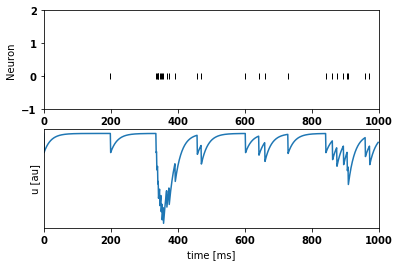

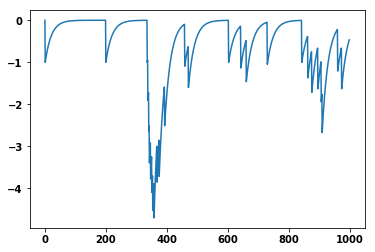

In [57]:
dclllib.plotLIF(U=Rprobe, S=Sprobe, staggering=5);
plt.plot(Rprobe)

Now we're in buisiness for learning. Let's ask this one neuron to spike at times $M=[300,600,900]$, i.e. $\hat{y}[m]=1,\, \forall m \in M$. However, it is difficult to train a neuron in this fashion though, because the neuron's membrane potential cannot follow such a high frequency change. Let's convolve the target with an exponential kernel instead.

In [95]:
Nin = 100
T = 1000
Sin = torch.FloatTensor(dclllib.spiketrains(N=Nin, T=T, rates = np.ones([Nin])*25)).to(device)
layer1 = LIFDenseLayer(in_channels=Nin, out_channels=1).to(device)

In [96]:
yhat = np.zeros(T)
yhat[300]=1; yhat[600]=1; yhat[900]=1; 
yhat = np.convolve(yhat,np.exp(-np.linspace(0,1,100)/.1))
yhat_t = torch.FloatTensor(yhat).to(device)

Let's plot the target:

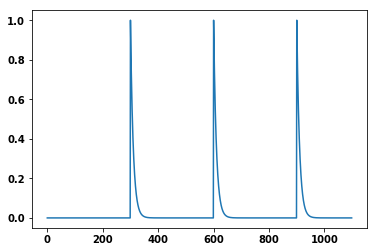

In [97]:
plt.plot(yhat)

Now we define the optimizer and the loss functions. We'll use an Adam optimizer to speed up learning.

In [98]:
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(layer1.parameters(), lr=1e-6, betas=[0., .95]) #lr is the learning rate 

for e in range(300):    
    loss_hist = 0
    for n in range(T):
        state, u = layer1.forward(Sin[n].to(device))
        loss_t = mse_loss(F.sigmoid(u).to(device),yhat_t[n])
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        loss_hist += loss_t
    if (e%20)==0: print(e, loss_hist)

0 tensor(264.3026, grad_fn=<ThAddBackward>)
20 tensor(19.0746, grad_fn=<ThAddBackward>)
40 tensor(18.2495, grad_fn=<ThAddBackward>)
60 tensor(18.3484, grad_fn=<ThAddBackward>)
80 tensor(19.4761, grad_fn=<ThAddBackward>)
100 tensor(20.3550, grad_fn=<ThAddBackward>)
120 tensor(20.9563, grad_fn=<ThAddBackward>)
140 tensor(21.7569, grad_fn=<ThAddBackward>)
160 tensor(22.6692, grad_fn=<ThAddBackward>)
180 tensor(22.5879, grad_fn=<ThAddBackward>)
200 tensor(22.9889, grad_fn=<ThAddBackward>)
220 tensor(23.1965, grad_fn=<ThAddBackward>)
240 tensor(22.8527, grad_fn=<ThAddBackward>)
260 tensor(23.4669, grad_fn=<ThAddBackward>)
280 tensor(22.5165, grad_fn=<ThAddBackward>)


After training, let's now test the output of this neuron,. You should see the neuron have a high membrane potential around the trained times, and hopefully spiking at the designated times. It may require more epochs to reach the target, but it'll eventually get there. It is also possible that the neuron spikes multiple times since we smoothed the target. 

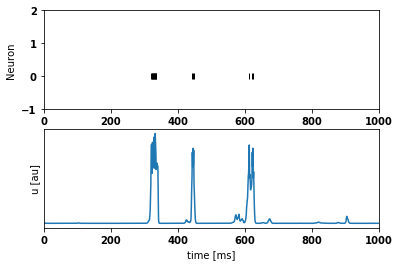

In [100]:
Sprobe = np.empty([T,1])
Uprobe = np.empty([T,1])
readProbe = np.empty([T,1])
for n in range(T):
    state, u = layer1.forward(Sin[n])
    Uprobe[n] = u.clone().data.cpu().numpy()
    Sprobe[n] = state.S.clone().data.cpu().numpy()
    readProbe[n] = F.sigmoid(u).data.numpy()
dclllib.plotLIF(U=readProbe, S=Sprobe);

## Training with fixed, random readouts

When designing the loss function, we assumed a non-linear readout of the layer of neurons. Let's take that idea further, and introduce a random readout of the layer. This idea is directly inspired by local errors described in <a href="https://www.frontiersin.org/articles/10.3389/fnins.2018.00608/full">(Mostafa, Ramesh Cauwenberghs, 2018)</a>. Let's assume that these random weights are not trainable. Because this is a random readout, we can also play with the dimensionality of the layer of spiking neurons. For example, here the spiking network consists of Nout = 256 neurons, even though our output is a scalar.


In [120]:
Nout = 128
layer1 = LIFDenseLayer(in_channels=Nin, out_channels=Nout).to(device)
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(layer1.parameters(), lr=1e-5, betas=[0., .95]) #lr is the learning rate 
random_readout = nn.Linear(Nout,1).to(device)

Note that because we do not introduce the random_readout parameters to in the optimizer, they will not be trained. For DCLL this is example what we want, and a deeper motivation for this can be found in <a href="https://www.frontiersin.org/articles/10.3389/fnins.2018.00608/full">(Mostafa, Ramesh Cauwenberghs, 2018)</a> and <a href="https://arxiv.org/abs/1811.10766">(Kaiser, Mostafa, Neftci, 2019)</a>.

In [ ]:
for e in range(300):    
    loss_hist = 0
    for n in range(T):
        state, u = layer1.forward(Sin[n])
        #This is where we introduce the random readout
        loss_t = mse_loss(random_readout(F.sigmoid(u)),yhat_t[n])
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        loss_hist += loss_t
    if (e%20)==0: print(e, loss_hist)

0 tensor(86.0938, grad_fn=<ThAddBackward>)
20 tensor(12.9498, grad_fn=<ThAddBackward>)
40 tensor(10.1775, grad_fn=<ThAddBackward>)
60 tensor(9.3970, grad_fn=<ThAddBackward>)
80 tensor(8.2861, grad_fn=<ThAddBackward>)
100 tensor(7.7356, grad_fn=<ThAddBackward>)
120 tensor(7.4374, grad_fn=<ThAddBackward>)
140 tensor(7.1599, grad_fn=<ThAddBackward>)
160 tensor(6.7511, grad_fn=<ThAddBackward>)


In [ ]:
Sprobe = np.empty([T,Nout])
readProbe = np.empty([T,1])
for n in range(T):
    state, u = layer1.forward(Sin[n])
    Sprobe[n] = state.S.clone().data.cpu().numpy()
    readProbe[n] = random_readout(F.sigmoid(u)).data.cpu().numpy()
    
dclllib.plotLIF(U=readProbe, S=Sprobe)
#plt.plot(F.sigmoid(torch.Tensor(Uprobe)).data.numpy())

You can see that the spiking neural netowrk activity appears now random and unrelated to the task. This is normal and due to the random projection (random_readout). The readout in the bottom panel however follows the target yhat.

Congratulations, you've built your first DCLL layer! With DCLL, the layer are simply stacked onto each other. When stacking, it is important to control the firing rate of the inputs and the outputs, and this can be done using regularization. The article <a href="https://arxiv.org/abs/1811.10766">(Kaiser, Mostafa, Neftci, 2019)</a> includes this and other bells and whistles, such as convolutional layers, regularization, batch trainining, random neuron time constants, learning rate adjustment to improve performance on real classification tasks, but the basics are here. In the following, the tutorial will describe how to overcome the continuous readout.

## Using custom activation layers

Coming Soon

## DCLL on Classification Tasks

### Loading MNIST data as spiketrains

The following function will load the MNIST dataset using torchvision modules. It'll download an pre-pre-process the data for faster usage.

In [16]:
gen_train = dclllib.get_mnist_loader(100, train=True)
gen_test = dclllib.get_mnist_loader(100, train=False)

Pre-processing dataset: 100%|██████████| 10000/10000 [00:00<00:00, 11696.05it/s]


Because MNIST is an image, we need to transform it into a spiketrain. The function image2spiketrain takes case of this.

In [28]:
datait = iter(gen_train)
raw_input, raw_labels = next(datait)
data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=1000, gain=100)
data_t = torch.FloatTensor(data)
labels_t = torch.Tensor(labels1h)

Let's examine the shape of data:

In [ ]:
data.shape

1000 here corresponds to the number of time setps, 100 is the batchsize, 1 is the number of channels and 28,28 are the height and width, respectively. The last three dimensions will important when we'll use convolutional or locally connected layers, but for the moment, our network has no structure,, so we will flatten them.

Here is what one sample looks like

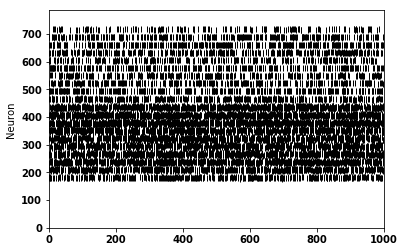

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa23ada3898>, None)

In [33]:
dclllib.plotLIF(U=None,S=data_t[:,0].view(1000,-1).data.numpy())

The average reate here is more revealing. Our MNIST input spike trains are simply flattened spiketrains representing the digit image in the firing rates.

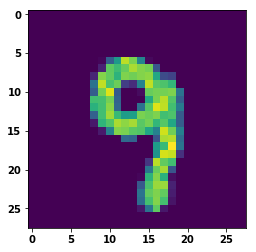

In [36]:
plt.imshow(data_t[:,0].data.numpy().mean(axis=0).reshape(28,28))

Let's create a function that does all these steps:

In [37]:
def next_mnist_batch(datait, batchsize=100, T=1000, max_rate = 100):
    raw_input, raw_labels = next(datait)
    data, labels1h = dclllib.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate)
    data_t = torch.FloatTensor(data).view(T,batchsize,-1)
    labels_t = torch.Tensor(labels1h)
    return data_t, labels_t  